In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LSTM, TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
input_shape=[200,200,3]
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

In [2]:
img_height, img_width = 128, 128  # Adjust as needed
batch_size = 32
num_classes = 2
num_channels = 3  # Assuming RGB images
patch_size = 4  # Size of each patch

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    #preprocessing_function=to_grayscale_then_rgb,
    validation_split=0.27)

train_generator = train_datagen.flow_from_directory(
    r"C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\ASD\Contrasted\Dataset",
    target_size=(img_height, img_width),
    batch_size=8,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    r"C:\Users\786me\Desktop\FinalYearProject\ASDScanPath\ASD\Contrasted\Dataset", # same directory as training data
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='binary',
    subset='validation')

Found 400 images belonging to 2 classes.
Found 147 images belonging to 2 classes.


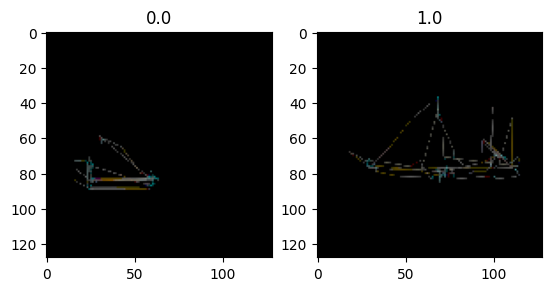

In [4]:
images, labels = train_generator.next()

fig, axes = plt.subplots(1, 2)
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(labels[i])
# show the figure
plt.show()

In [5]:
model = tf.keras.models.Sequential()

# CNN layers
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(img_height, img_width, num_channels)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [6]:
# Flatten the feature maps and reshape them into sequences
model.add(Flatten())
sequence_length = img_height // (2 ** 2)  # Assuming two max-pooling layers
model.add(Reshape((sequence_length, -1)))  # Reshape into a sequence of feature vectors

In [7]:
# LSTM layer
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32)) 
# Fully connected layer and output
# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))

#Outputlayer
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 reshape (Reshape)           (None, 32, 1800)          0

In [8]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/10
50/50 [==============================] - 16s 199ms/step - loss: 0.6689 - accuracy: 0.5950 - val_loss: 0.5962 - val_accuracy: 0.7007
Epoch 2/10
50/50 [==============================] - 9s 176ms/step - loss: 0.6454 - accuracy: 0.6075 - val_loss: 0.6046 - val_accuracy: 0.5986
Epoch 3/10
50/50 [==============================] - 9s 177ms/step - loss: 0.6094 - accuracy: 0.6550 - val_loss: 0.5546 - val_accuracy: 0.7551
Epoch 4/10
50/50 [==============================] - 9s 178ms/step - loss: 0.5539 - accuracy: 0.7250 - val_loss: 0.4975 - val_accuracy: 0.7279
Epoch 5/10
50/50 [==============================] - 9s 177ms/step - loss: 0.5403 - accuracy: 0.7475 - val_loss: 0.5389 - val_accuracy: 0.7415
Epoch 6/10
50/50 [==============================] - 9s 178ms/step - loss: 0.5104 - accuracy: 0.7525 - val_loss: 0.4777 - val_accuracy: 0.7687
Epoch 7/10
50/50 [==============================] - 8s 169ms/step - loss: 0.4961 - accuracy: 0.7500 - val_loss: 0.5029 - val_accuracy: 0.7483
Epoch

In [9]:
##Confusion Matrix Generator and ROC Curve
y_pred_real = model.predict(validation_generator)
y_pred = [int(p >= 0.5) for p in y_pred_real] ##With sigmoid 1 neuron
##y_pred = np.argmax(Y_pred, axis=1) ##With softmax and 2 neurons 
y_true = validation_generator.classes
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
print(cm)

147/147 [==============================] - 2s 9ms/step
[[45 43]
 [31 28]]
